# Ultimate challenge

## Part 1) EDA

Directions: 

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from sklearn.metrics import classification_report, accuracy_score

import warnings

#def fxn():
#    warnings.warn("deprecated", DeprecationWarning)

#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
#    fxn()

plt.style.use('seaborn')


In [2]:
# Load json into dataframe
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
#converting login_time to datetime
df['login_time'] = pd.to_datetime(df['login_time'])

In [4]:
#desribe data
#change datetime to numeric
df.describe()

<ipython-input-4-672d58e900fe>:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
#check for null values
df.isnull().sum()

#Dataset looks good, no missing values

login_time    0
dtype: int64

In [6]:
#Setting the index to 'login_time'
#df = df.set_index(['login_time'])

#adding count column
df['count'] = 1

#set login time as index for resampling
df.index = df['login_time']

#drop redundant column
df.drop('login_time',axis=1,inplace=True)

df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [7]:
#reshaping data in 15 min intervals
df_15 = df.resample('15min').sum()
#df_15 = df_15.reset_index()

In [8]:
df_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


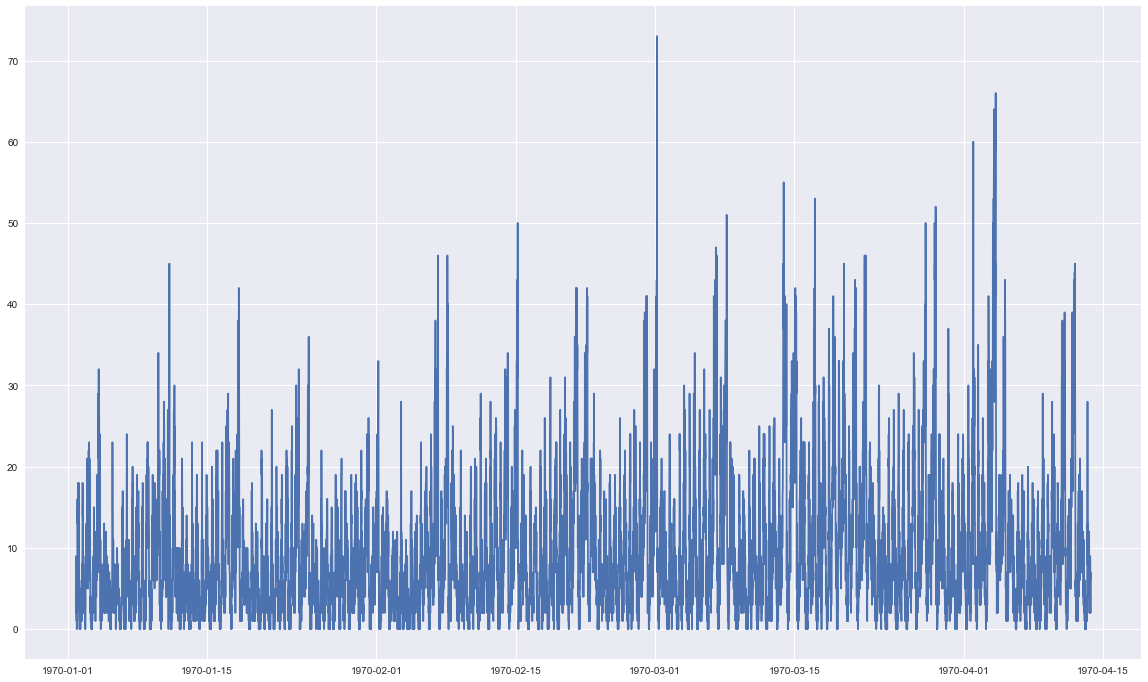

In [9]:
### plotting the entire dataset
plt.figure(figsize = (20,12))
plt.plot(df_15)

In [10]:
df_15.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


We can see from this that the maximum number of logins on a single day was 73, while the mean was just about 9.5. I want to find out roughly which day of the week and what time of the day has the most traffic volume.

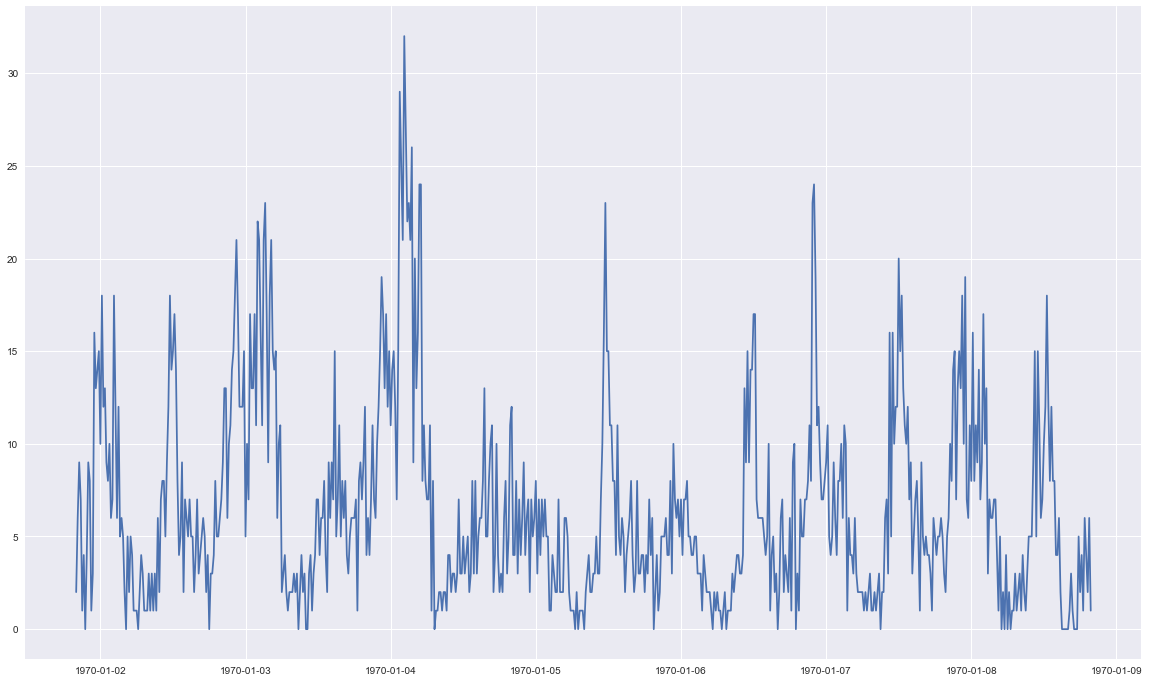

In [11]:
### plotting data for a week
plt.figure(figsize = (20,12))

#plotting a weeks worth of 15 min intervals (168 hours in a week x 4)
plt.plot(df_15[0:672])

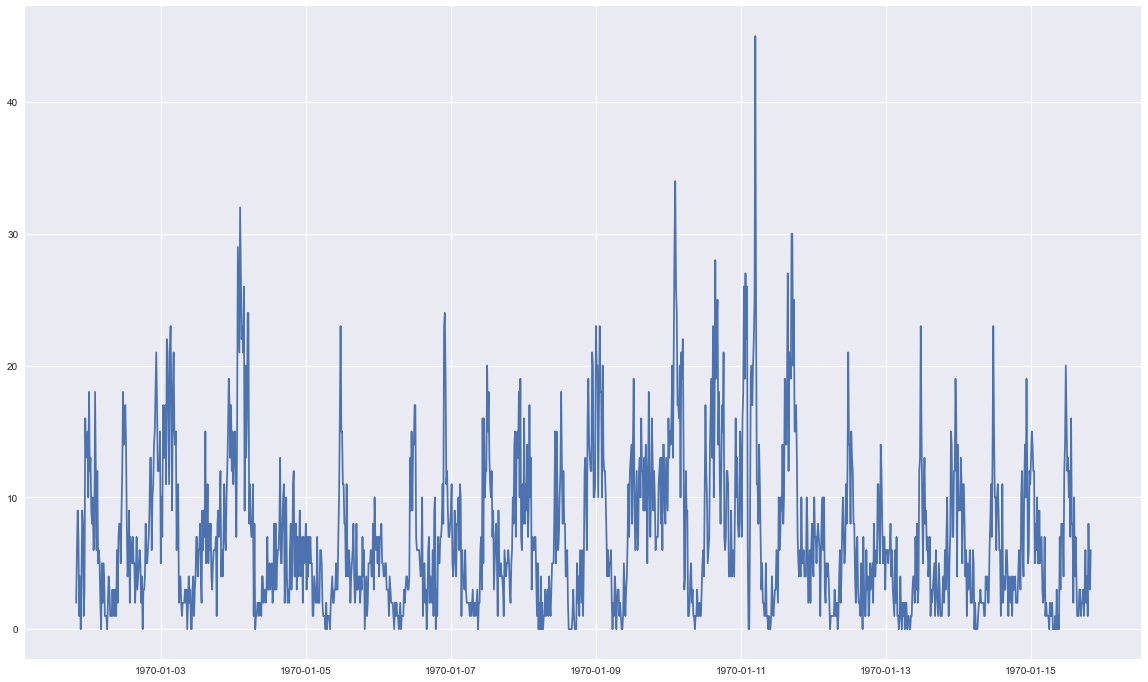

In [12]:
### plotting data for 2 weeks
plt.figure(figsize = (20,12))

#plotting a weeks worth of 15 min intervals (168 hours in a week x 4 x 2 weeks)
plt.plot(df_15[0:1344])

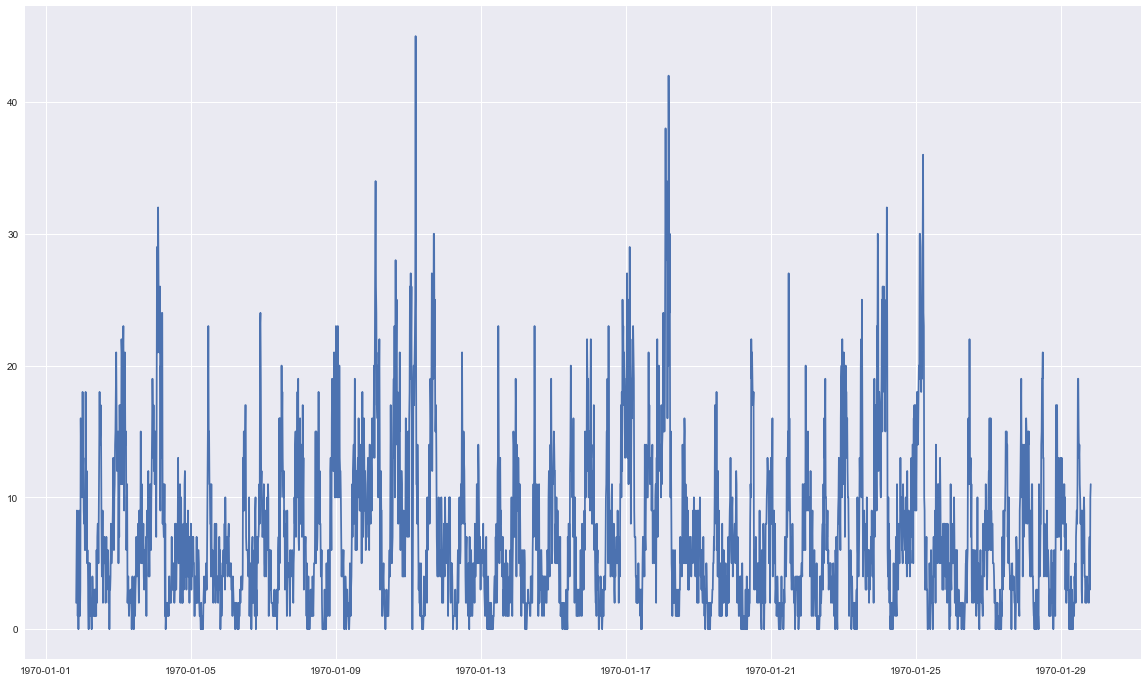

In [13]:
### plotting data for a month
plt.figure(figsize = (20,12))

#plotting a weeks worth of 15 min intervals (168 hours in a week x 4 x 4 weeks)
plt.plot(df_15[0:2688])

In [14]:
#resetting index
df_15 = df_15.reset_index()

In [15]:
#lookign at which day of the week the highest volume
df_15[df_15['count'] == 73]['login_time'][5602].dayofweek

6

In [16]:
#creating day of the week column
df_15['weekday'] = df_15['login_time'].dt.dayofweek

In [17]:
#dataset of weekdays
weekday = df_15.sort_values(by='count', ascending=False)

#count of logins by weekday
weekday_counts = weekday[['count', 'weekday']]
weekday_count = weekday_counts.groupby('weekday').sum().reset_index()

weekday_count

,weekday,count
0,0,8823
1,1,9268
2,2,10339
3,3,11960
4,4,15208
5,5,19377
6,6,18167


<AxesSubplot:xlabel='weekday', ylabel='count'>

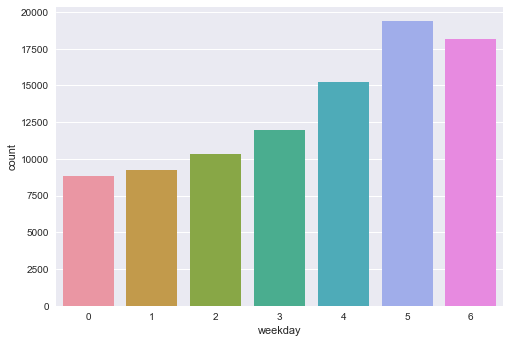

In [18]:
#Plotting weekday data
sns.barplot(x='weekday', y='count', data=weekday_count)

When plotting the data in 1 week, 2 week, and 1 month intervals, the highest spikes of the week usually always occur on the weekends, which is also in line with Sunday being the day of the week that had the highest volume of logins during the time the dataset collected its data, at 73. When plotting the full dataset it also appears that the number of logins increased gradually as time went on. We can also see that the weekly trend seems to shos that the traffic volume gradually increases from Monday (its lowest point of the week) all the way to peaking on Saturday.

## Part 2) Experiment and Metric Design

Directions:

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.


1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?


2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the
observation
c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


Answers:

1) The key metric of success would be the profit gained after reimbursement. I assume that money is the driving factor behind the desire to increase the activity between both cities. If the net profit gained after reimbursement from drivers who were reimbursed for toll costs was greater than the net profit of rider's who were not reimbursed, it would signify to me that the cost of reimbursing the driver's was worth it to increase profits.

2) I would want to do a simple A/B test to begin. I would start off by splitting the drivers into 2 groups. The first group would be reimbursed for toll costs, while the second group would not be reimbursed. After a set ammount of time (I would suggest 6 months) I would compare the results from both the tests by using a statistical significance t-test( p = 0.05) to test if the results were statistically significant. If the results were statistically significant and profits increased even after reimbursing the drivers, I would suggest to reimburse all drivers toll costs

# Part 3) Predictive Modeling

Directions:

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.


1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?


2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.


3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

Data Description:

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

### Data Wrangling and EDA

In [19]:
# Load json into dataframe
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [20]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
#change objects to dates
df['signup_date'] = pd.to_datetime(df.signup_date)
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)

In [23]:
#checking for missing values
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [24]:
#looking at average trips and average distance, for possible outliers
df.sort_values('trips_in_first_30_days', ascending = False )

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8
99,Astapor,73,2014-01-27,4.9,1.00,2014-03-05,Android,0.0,True,89.7,2.86,4.9
3030,Winterfell,71,2014-01-06,4.9,1.06,2014-06-28,iPhone,2.9,True,85.9,2.32,4.8
29070,Astapor,63,2014-01-10,4.0,1.07,2014-06-29,iPhone,7.3,True,83.3,1.45,4.6
48804,Astapor,58,2014-01-24,4.4,1.04,2014-06-05,iPhone,3.1,True,77.6,2.30,4.7
...,...,...,...,...,...,...,...,...,...,...,...,...
25498,Astapor,0,2014-01-13,5.0,1.00,2014-06-12,iPhone,0.0,False,100.0,6.65,5.0
25489,Winterfell,0,2014-01-26,4.0,1.00,2014-03-29,Android,0.0,True,0.0,2.71,4.0
25488,Astapor,0,2014-01-06,5.0,1.13,2014-06-30,iPhone,20.0,False,30.0,3.69,5.0
25482,Winterfell,0,2014-01-14,NaN,1.00,2014-04-07,iPhone,0.0,True,0.0,1.78,5.0


In [25]:
#looking at average trips and average distance, for possible outliers
df.sort_values('avg_dist', ascending = False )

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
20701,Astapor,0,2014-01-25,NaN,1.0,2014-06-26,Android,0.0,False,100.0,160.96,NaN
534,King's Landing,0,2014-01-04,NaN,1.0,2014-03-09,None,0.0,False,0.0,129.89,5.0
1302,Winterfell,1,2014-01-30,5.0,1.0,2014-01-30,iPhone,0.0,False,100.0,79.69,5.0
22290,Astapor,0,2014-01-12,5.0,1.0,2014-06-26,iPhone,0.0,True,100.0,79.34,5.0
47595,King's Landing,0,2014-01-25,5.0,1.0,2014-06-09,iPhone,0.0,True,0.0,77.13,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
24853,King's Landing,0,2014-01-15,NaN,1.5,2014-06-25,iPhone,100.0,False,100.0,0.00,5.0
23728,Astapor,1,2014-01-29,NaN,1.0,2014-01-29,Android,0.0,False,100.0,0.00,5.0
35726,Winterfell,1,2014-01-05,NaN,1.0,2014-02-02,iPhone,0.0,False,0.0,0.00,2.0
24946,Winterfell,1,2014-01-04,NaN,1.0,2014-01-05,Android,0.0,False,0.0,0.00,1.0


In [26]:
#filling in missing values, with the mean
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

In [27]:
#dropping rows with no phone data
df = df.drop(df[df.phone.isna()==True].index,axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [28]:
#checking for no missing values, dataset looks good and ready for analysis
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [29]:
#setting current date of when dataset collected
current = df.last_trip_date.max()

#defining active user as user who was active within the last 30 days from when dataset collected
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current-date).days>30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [30]:
print('The percent of users who are active is ' + str(df.active.sum() / df.active.count()) + '%')

The percent of users who are active is 0.37640109668575117%


### Preprocessing

In [31]:
# One-hot-encode categorical features
df = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [32]:
#Train Data

X = df.drop(['signup_date','last_trip_date','active'], axis = 1)
y = df.active

#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

In [33]:
X.shape

(49604, 14)

In [34]:
y.shape

(49604,)

In [35]:
#Finding optimal random forest parameters
rfc = RandomForestClassifier()

#First thing I want to do is test for the optimal parameters
rfc_params = {'min_samples_leaf': [1, 3, 5, 10, 20], 
              'max_depth': [2, 4, 5, 10, 12, 16, 20], 
             }

rfc_gcv = GridSearchCV(rfc, rfc_params, n_jobs=1, cv=StratifiedKFold(3), scoring='roc_auc')
rfc_gcv.fit(X_train, y_train)
rfc_gcv.best_params_, rfc_gcv.best_score_

({'max_depth': 12, 'min_samples_leaf': 10}, 0.8484073135631413)

In [36]:
#Fitting to Random Forest classifier with optimal parameters
rf = RandomForestClassifier(max_depth = 12, min_samples_leaf = 10)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

#Checking accuracy of model
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score:  0.7823808083862513
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      6124
           1       0.76      0.64      0.69      3797

    accuracy                           0.78      9921
   macro avg       0.78      0.76      0.76      9921
weighted avg       0.78      0.78      0.78      9921



In [37]:
#feature importance
imp = pd.Series(rf.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

avg_rating_by_driver         0.154641
surge_pct                    0.142381
weekday_pct                  0.122164
city_King's Landing          0.107790
avg_surge                    0.095356
avg_dist                     0.066072
trips_in_first_30_days       0.065940
phone_Android                0.046751
phone_iPhone                 0.040969
ultimate_black_user_True     0.039140
avg_rating_of_driver         0.034342
city_Astapor                 0.033072
ultimate_black_user_False    0.031528
city_Winterfell              0.019854
dtype: float64


In [38]:
#Checking accuracy after SCALING Data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [39]:
#Fitting Scaled data to Random Forest classifier with optimal parameters
rf2 = RandomForestClassifier(max_depth = 12, min_samples_leaf = 10)

rf2.fit(X_train_scaled, y_train)

y_pred2 = rf2.predict(X_test)

#Checking accuracy of model
print('Accuracy score: ', accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy score:  0.6337062796089104
              precision    recall  f1-score   support

           0       0.65      0.88      0.75      6124
           1       0.55      0.24      0.33      3797

    accuracy                           0.63      9921
   macro avg       0.60      0.56      0.54      9921
weighted avg       0.61      0.63      0.59      9921



In [40]:
#feature importance of scaled Random forest model
imp = pd.Series(rf2.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

avg_rating_by_driver         0.178317
surge_pct                    0.126863
weekday_pct                  0.121207
city_King's Landing          0.111889
avg_surge                    0.085085
trips_in_first_30_days       0.066679
avg_dist                     0.066574
phone_Android                0.051343
phone_iPhone                 0.039233
ultimate_black_user_False    0.035630
ultimate_black_user_True     0.034096
avg_rating_of_driver         0.033382
city_Astapor                 0.030457
city_Winterfell              0.019245
dtype: float64


By using a Random Forest Classification model with tuned optimal parameters, I was able to build a model that could determine an active user with over 78% accuracy.

While scaling the data did not improve the models accuracy, it did confirm several feature importances. Average rating by the driver seems to be the most import feature to determine wether a user is an active user, followed by  weekday_pct and surge_pct. It did not seem to make much of a difference whether the user was an android or iphone user. The city that had the highest feature importance was King's landing. 